#QSB Project

In [1]:
%matplotlib inline

# import csv
import matplotlib.pyplot as plt 
import numpy as np
from scipy.optimize import curve_fit
from pysb import *
from pysb.macros import *
import pylab as pl
from pysb.integrate import odesolve, Solver
import pandas as pd
from IPython.display import HTML
from scipy.stats import stats
from scipy.spatial.distance import pdist
from copy import deepcopy

##Sensitivity analysis
In this section, the importance of each parameter will be assessed.  
In this analysis, the output (on idividual molecules) of the original model will be compared with the output of a model where one parameter has been changed

###Distance and statistics
Since the parameter space is the same in both the experiment (modified model) and the control (model fitted from experiments), an euclidean distance was chosen as a measure of distance.  
It has to be noted, that the euclidean distance is susceptible to complementary fluctuations, as seen below

Import model

In [2]:
import qsb_model as m

In [132]:
sum(abs(original[1:]-original[:-1]))

0.99993068263821483

In [179]:
np.log2(0)

-inf

In [172]:
def DLK(u,v,epsilon,bg):
    '''
    Calculate Kullback-Leibler divergence
    u,v: numpy arrays
    e: epsilon -> pseudocounts to add
    bg: background weight. Under a uniform distribution, bg is 1/(4^k)
    '''
    ps_count = epsilon * bg
    # Get proportions and add pseudocount
    
    u_prop = abs(u[1:] - u[:-1])
    u_with_first = np.insert(u_prop,0,u_prop[0]+ps_count)
    u_norm = u_with_first / 
    
    v_prop = abs(v[1:] - v[:-1]) + ps_count
    v_with_first = np.insert(v_prop,0,v_prop[0]+ps_count)
    
    
    dlk = sum(u_with_first * np.log2(u_with_first/v_with_first))
    return dlk

In [197]:
reload(m)
# Extract initial conditions (We are not going to change these
initial_conditions = [x[1] for x in m.model.initial_conditions]
# Filter out initial concentrations from the parameters that we are going to use
params_to_change = [param for param in m.model.parameters if not param in initial_conditions]

def messed_up_param(model,param,out_var,samples):
    '''
    Measure the extent at which modifying a parameter of a model
    will change the production of a molecule specified by it
    input: 
    model: pysb model
    param: parameter to be evaluated
    out_var: output molecule to me measured
    order_magnitude: The parameter will be modified X orders of 
    magnitude below and above its experimentally fitted value
    samples: samples to be generated
    '''
    # This dictionary maps the outputs with its initial conditions
    init_condition = {'mBid':'Bid_0','aSmac':'Smac_0','cPARP':'PARP_0'}
    # set integration interval
    t = np.linspace(0,200000)
    # Store original parameter value
#     print(param.value)
    old_param_value = np.real(param.value)
    # The parameter will be modified _samples_ times
    # from half to 2 times its original value
    
    # Solve the ODE system for the original model
    yout_old = odesolve(model.model, t)
    # Extract output variable to be analyzed
    analyte = yout_old[out_var] / model.model.parameters[init_condition[out_var]].value
#     print("Parameter {} will be scanned for deviations on {} production".format(param.args[0],out_var))
    sample_output = {}
    news = []
    value_list = np.linspace(old_param_value/2,old_param_value*2,samples)
    for value in value_list:
        # Set the parameter to the new value
        param.value = value
        # Solve the ODE
        Solver(model.model,t)
        yout = odesolve(model.model,t)
        # Extract the values of the analyte that is being compared
        new_analyte = yout[out_var] / model.model.parameters[init_condition[out_var]].value
        news.append(new_analyte)
        # Measure the LKD
#         dlk = DLK(analyte,new_analyte,1,1/analyte[-1])
        euclidean = pdist([analyte,new_analyte])
        # Store result in dictionary
        sample_output[value] = [euclidean[0]]
        # Organize result as a table
        sample_output_table = pd.DataFrame.from_dict(sample_output,orient='index')
        sample_output_table.columns=['euclidean']
        sample_output_table.index.name = param.args[0]
        sample_output_table.reset_index(inplace=True)
        sample_output_table.sort(param.args[0],inplace=True)
        sample_output_table.set_index(param.args[0],inplace=True)
    return sample_output_table,news,value_list,analyte,old_param_value

qsb_model.py:60: ModelExistsWarning: Redefining model! (You can probably ignore this if you are running code interactively)
  Model()


In [198]:
perturbations = {}
for output in ['mBid','aSmac','cPARP']:
    print(output)
    perturbations[output] = {param.args[0]: messed_up_param(m,param,output,1000) for param in params_to_change}

mBid
aSmac
cPARP


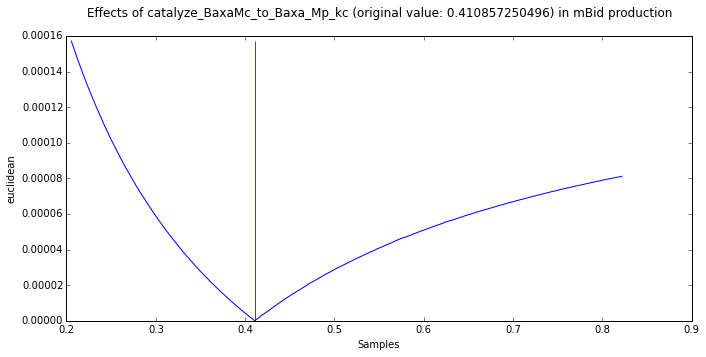

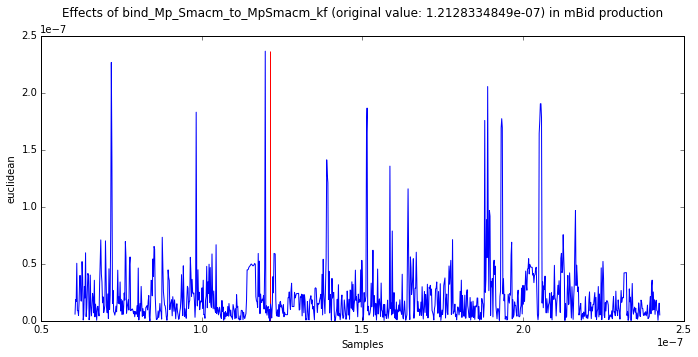

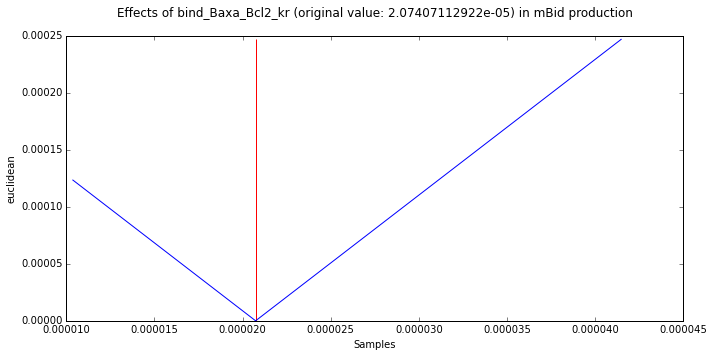

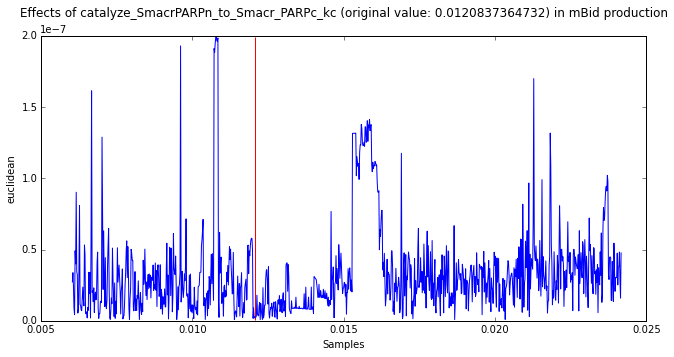

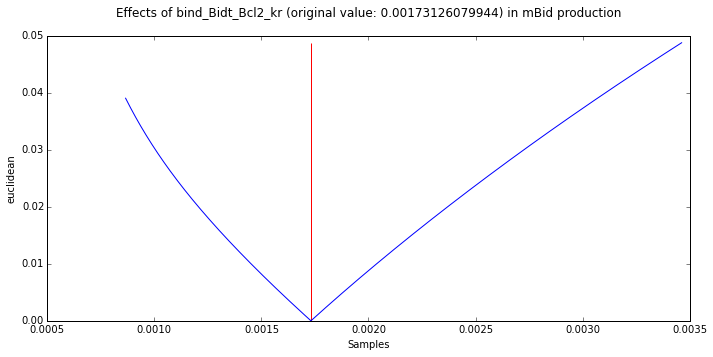

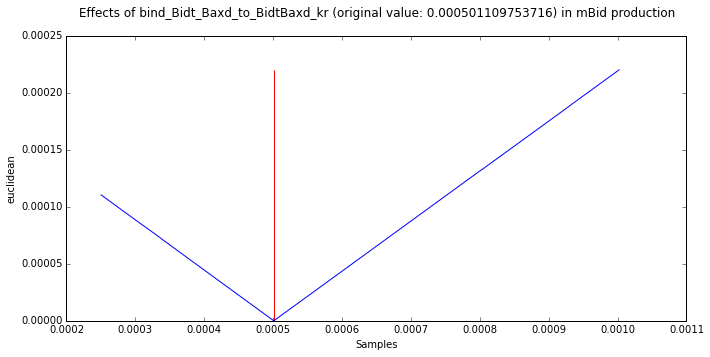

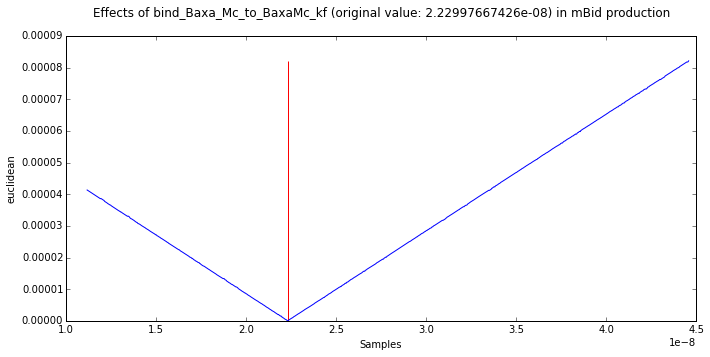

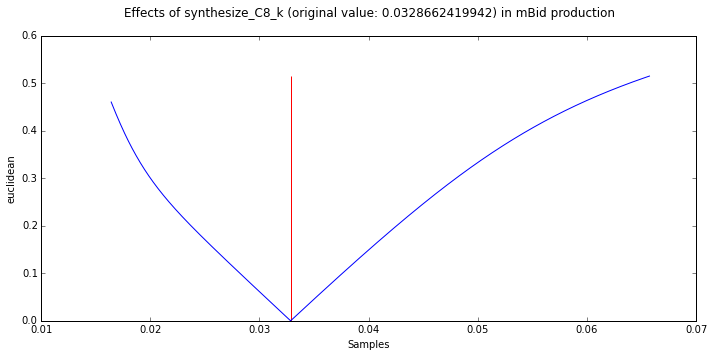

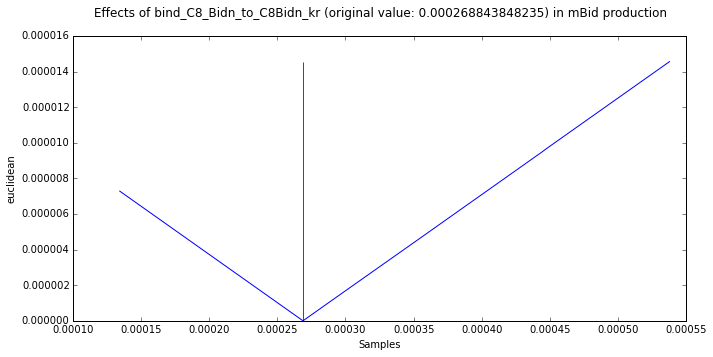

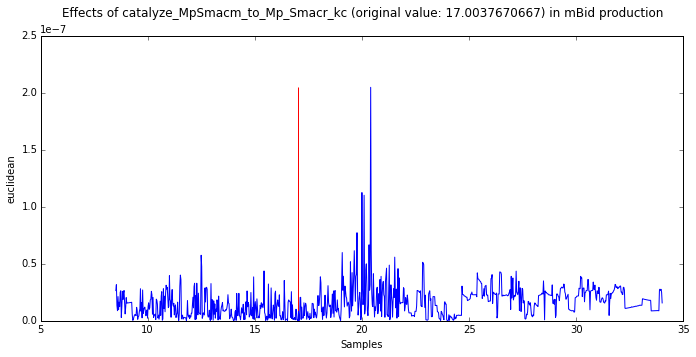

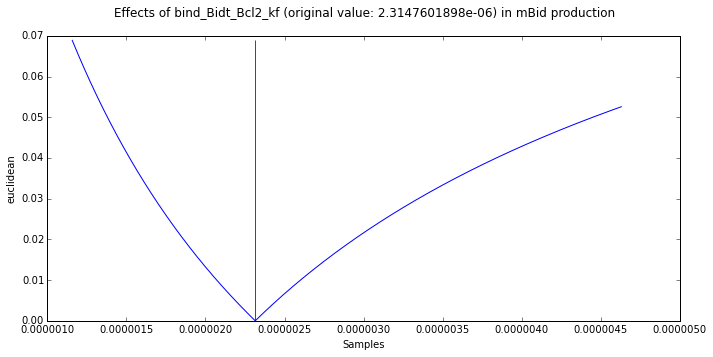

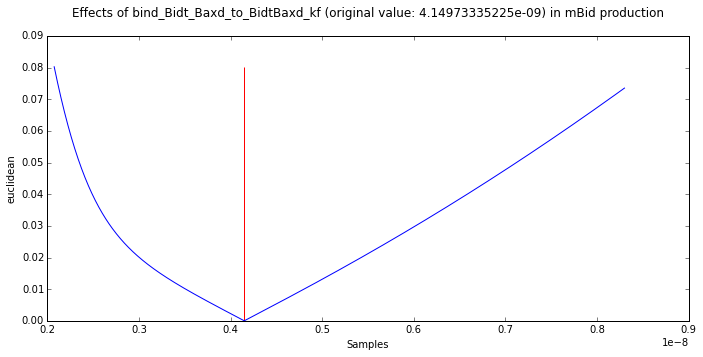

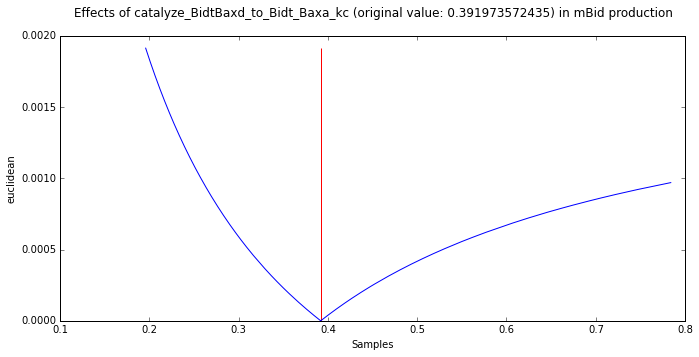

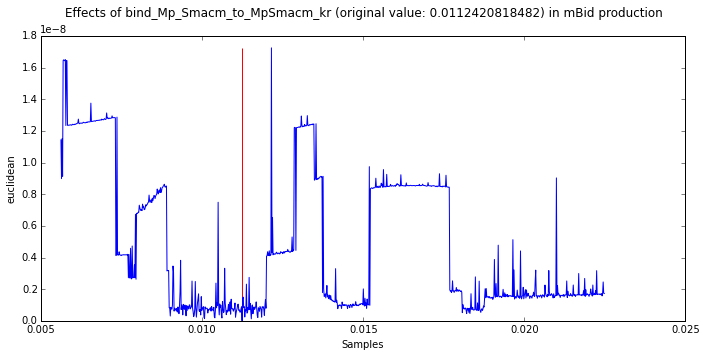

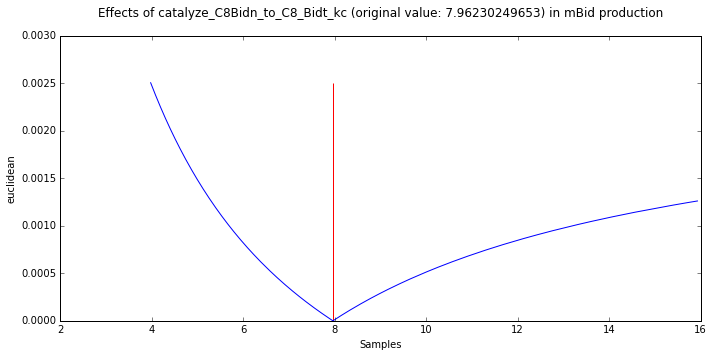

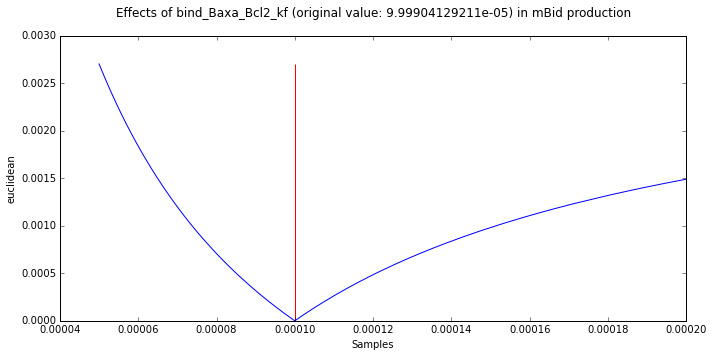

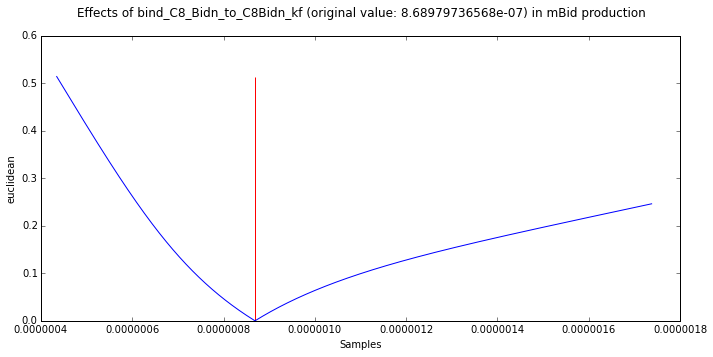

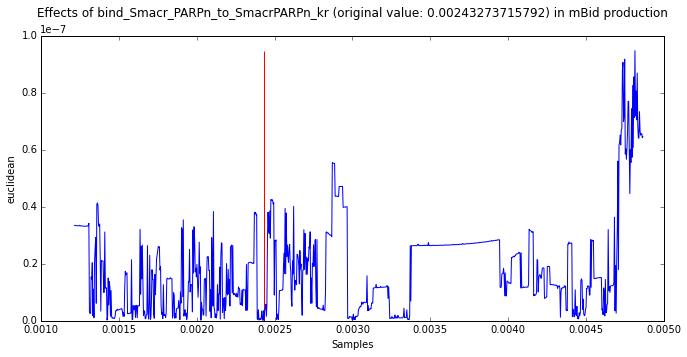

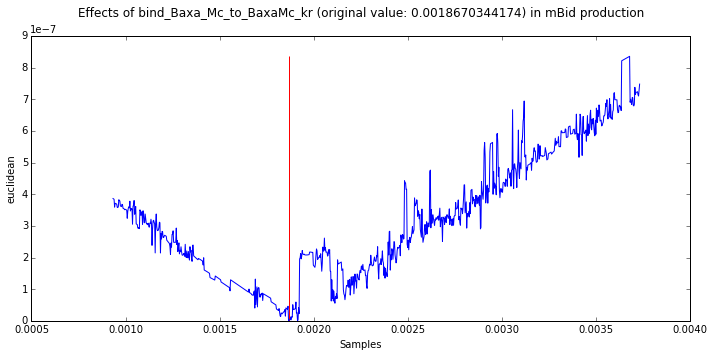

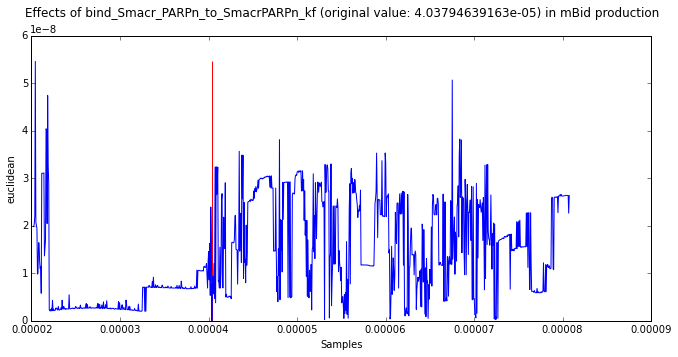

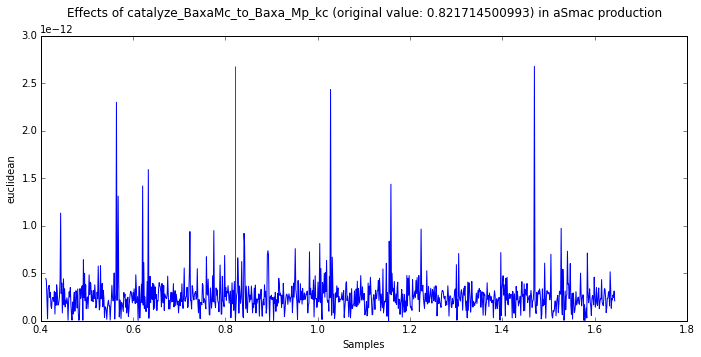

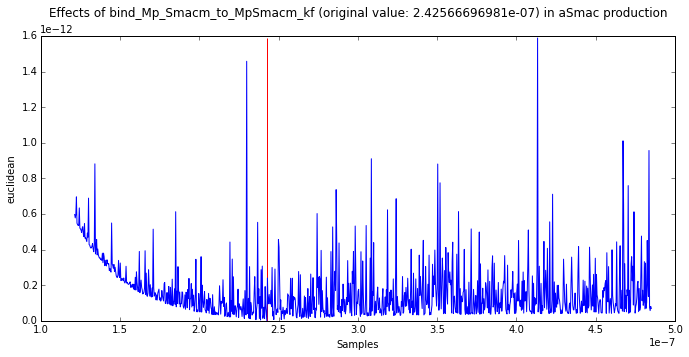

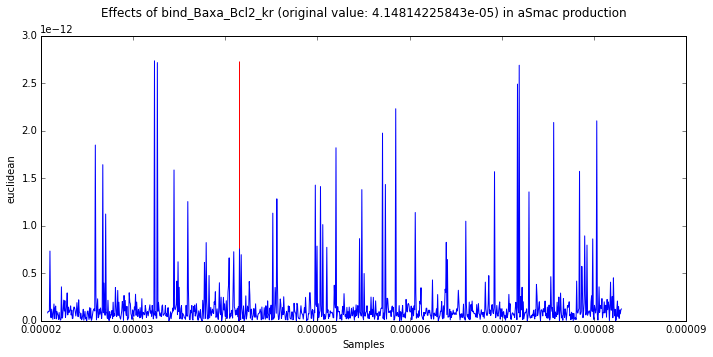

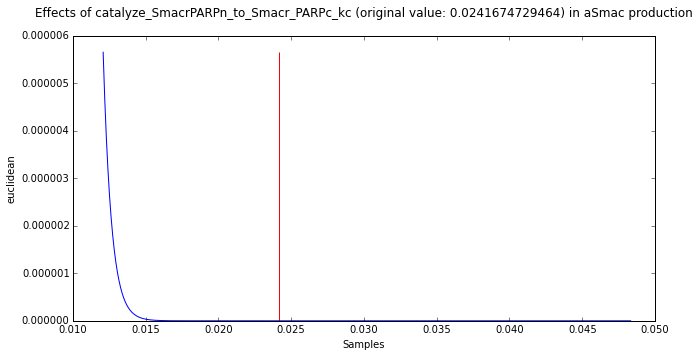

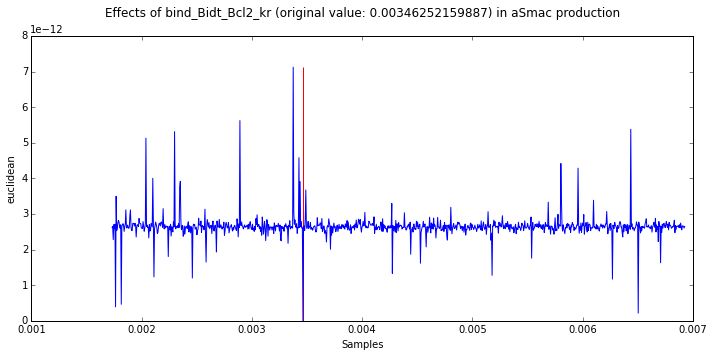

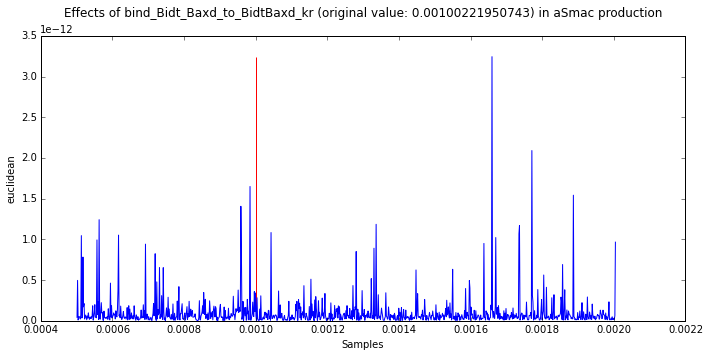

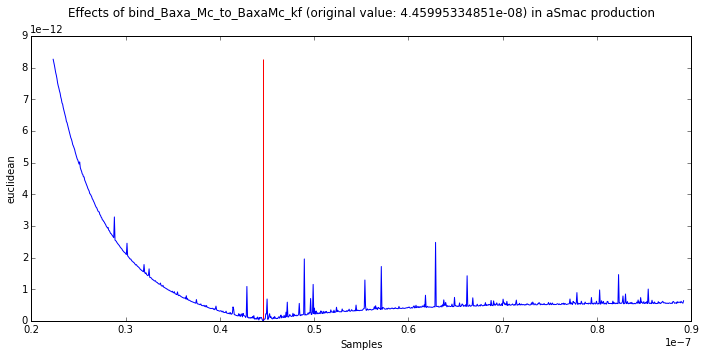

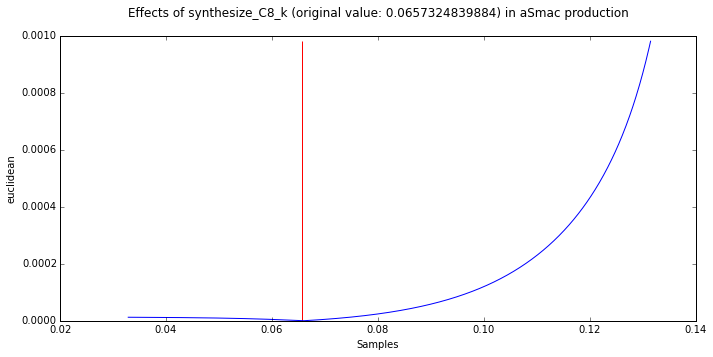

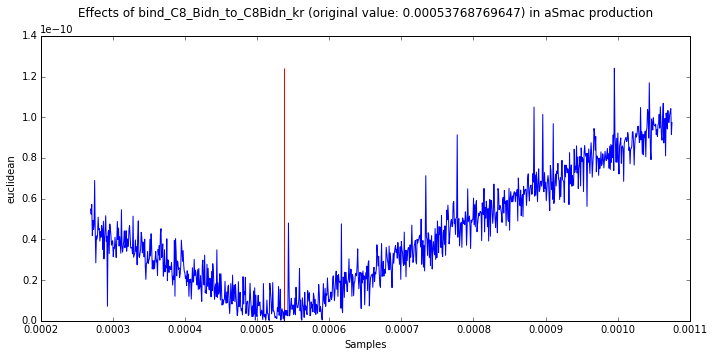

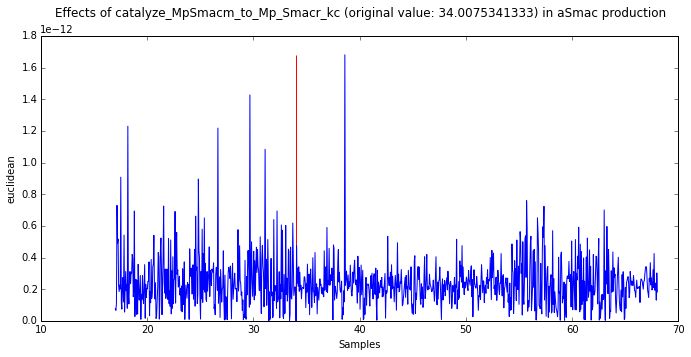

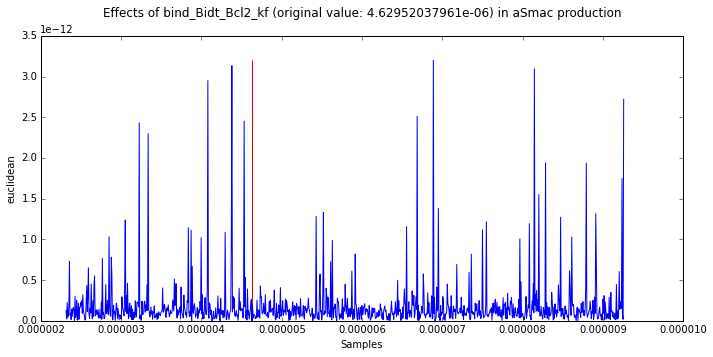

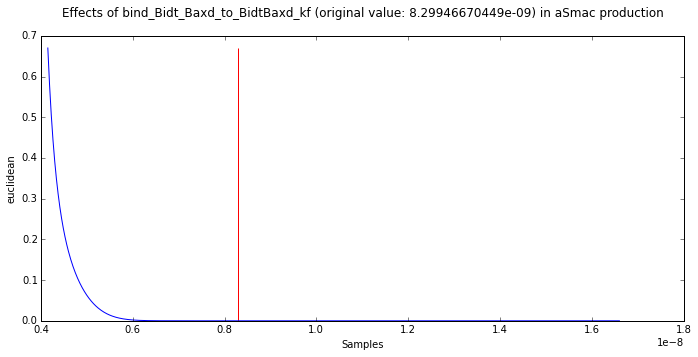

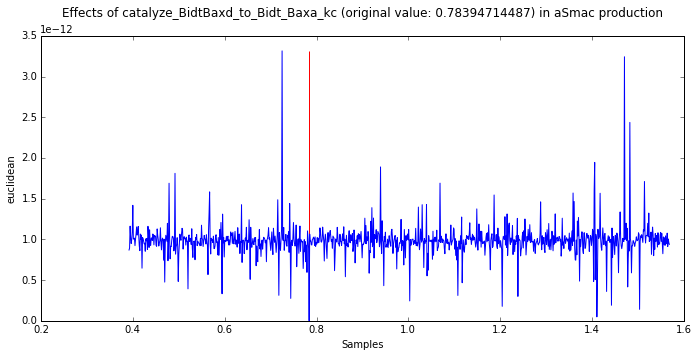

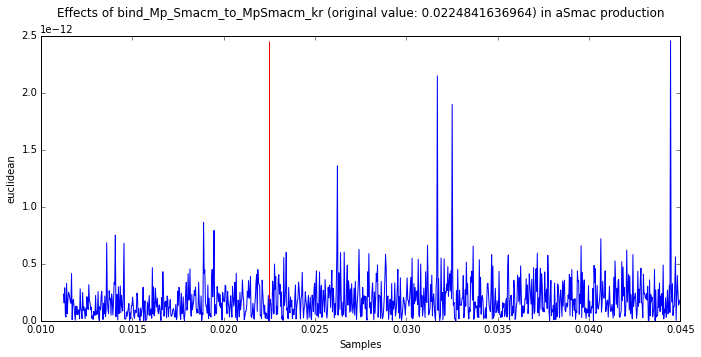

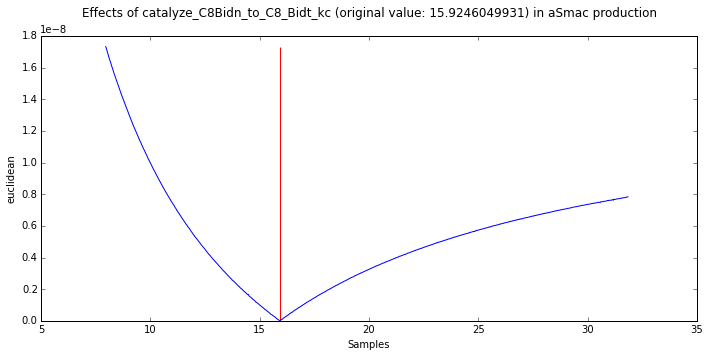

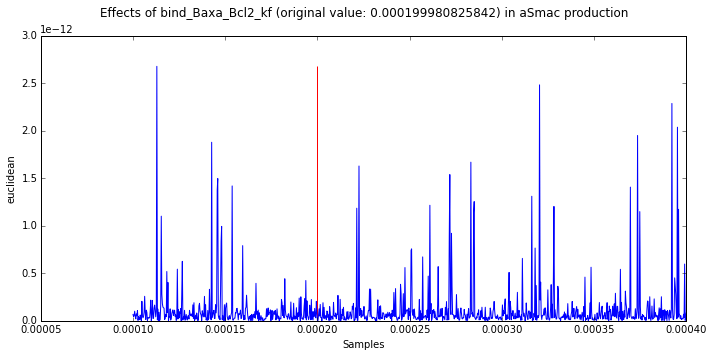

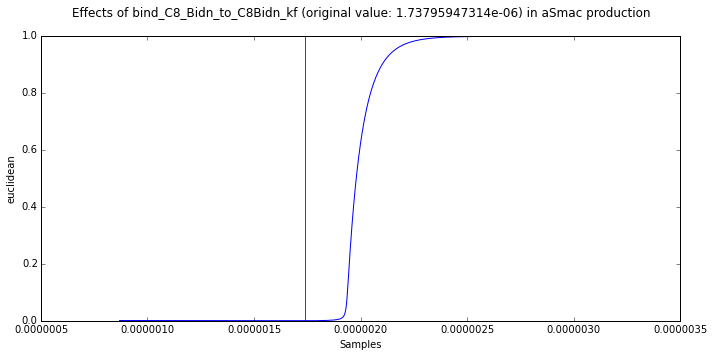

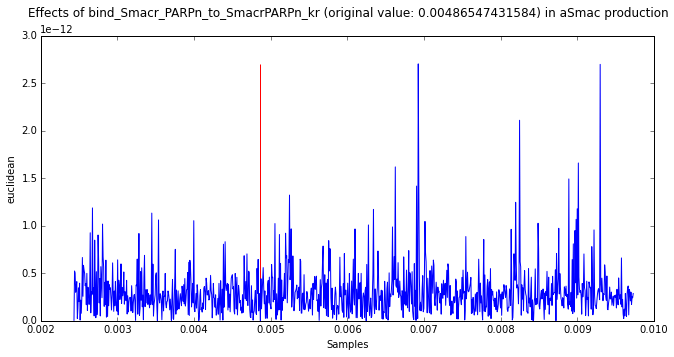

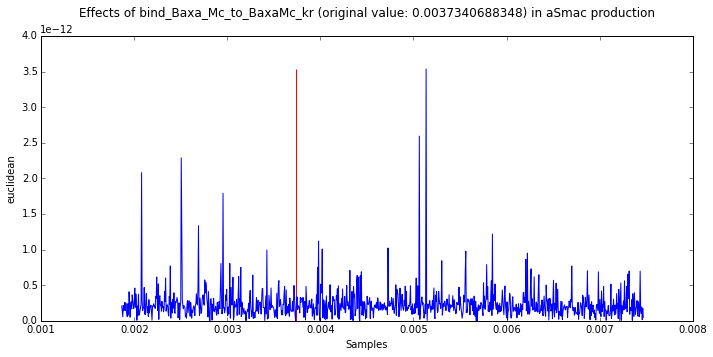

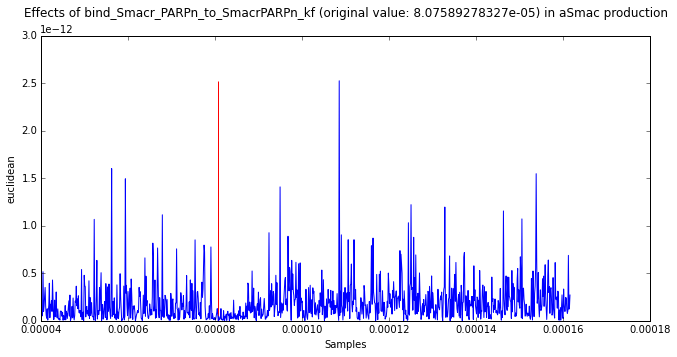

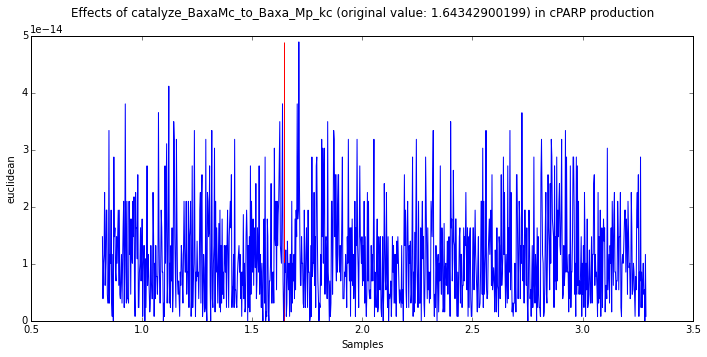

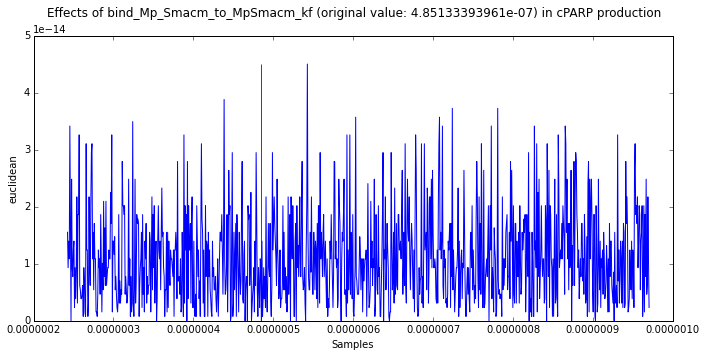

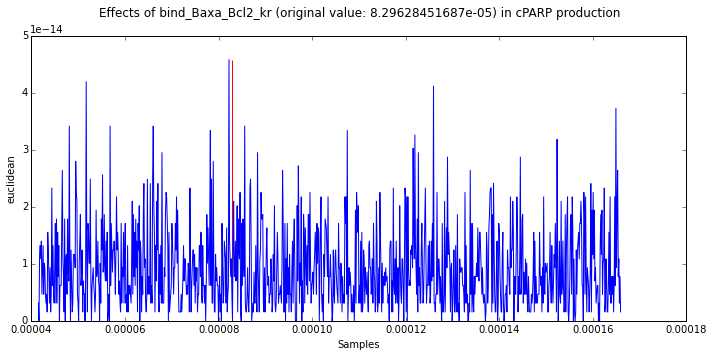

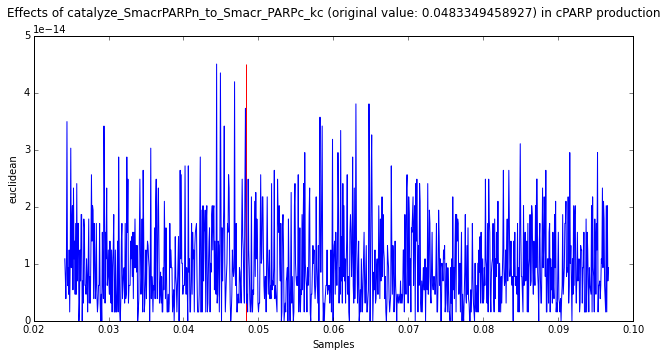

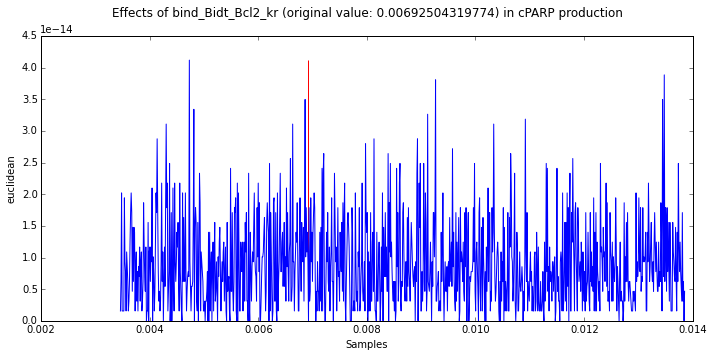

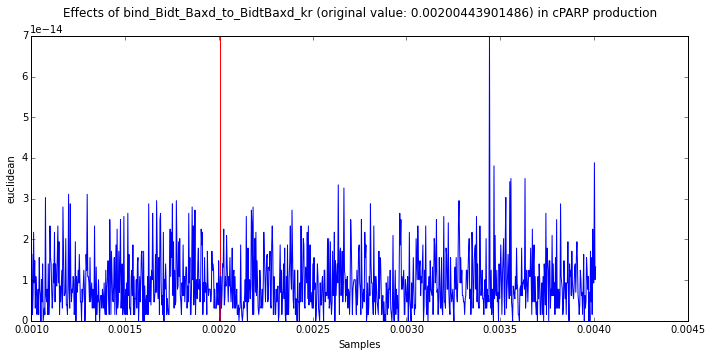

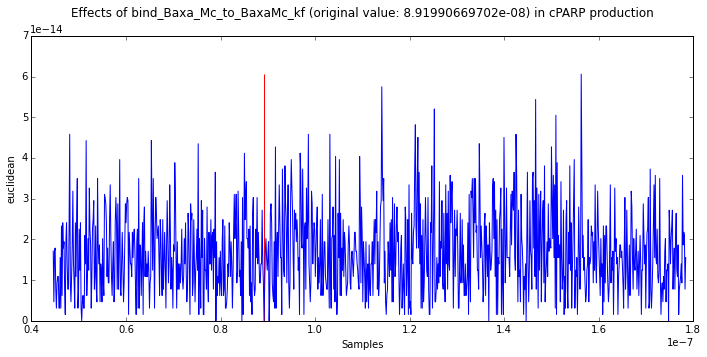

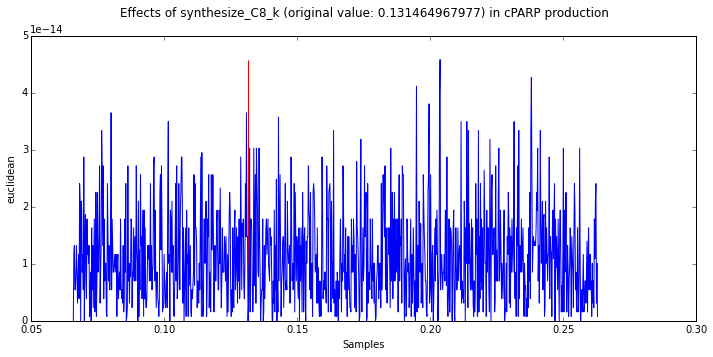

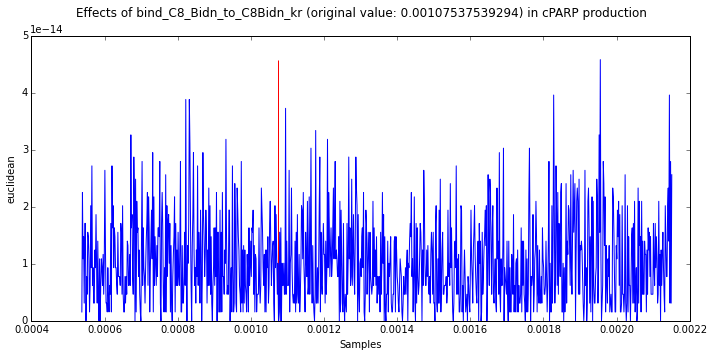

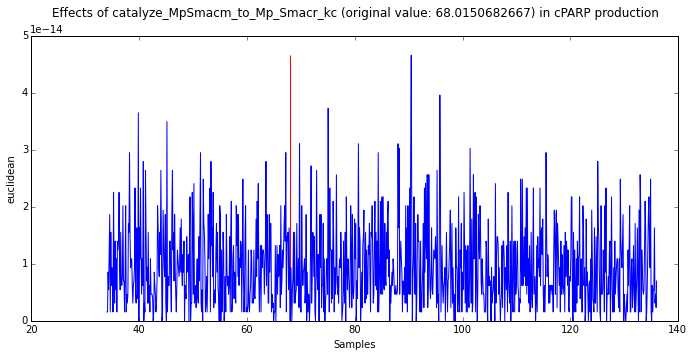

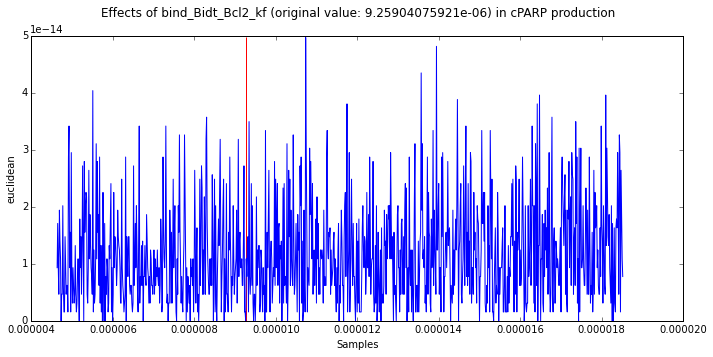

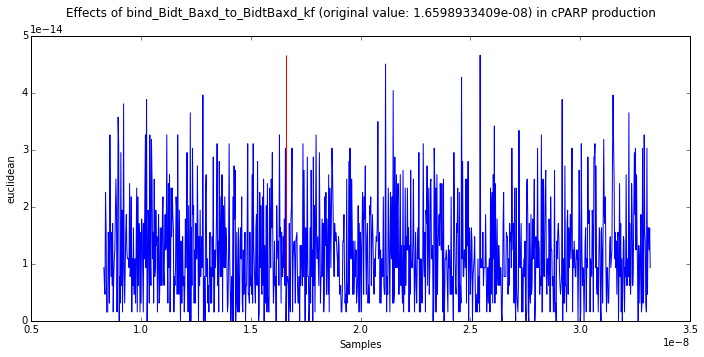

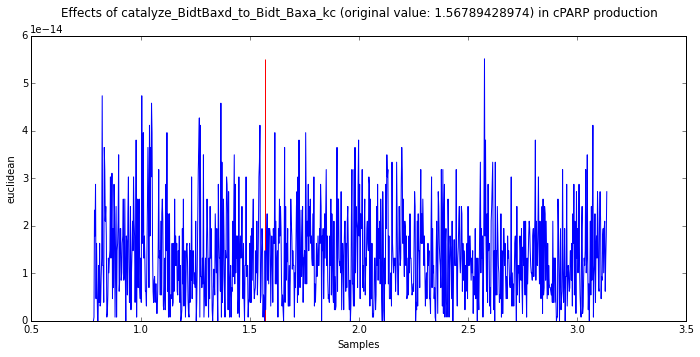

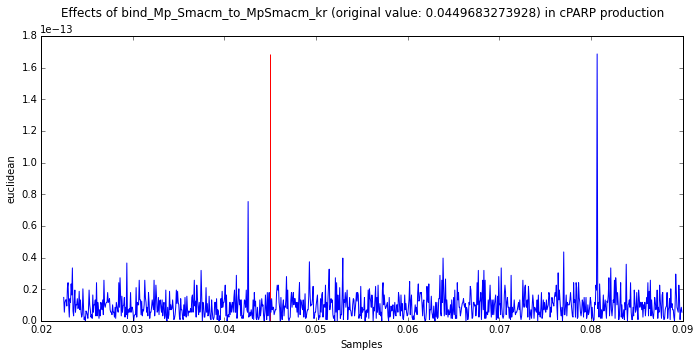

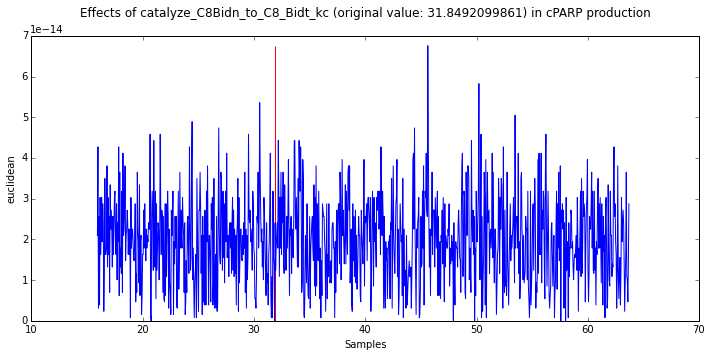

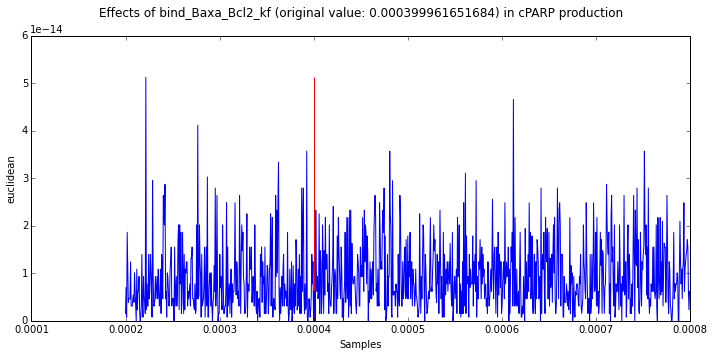

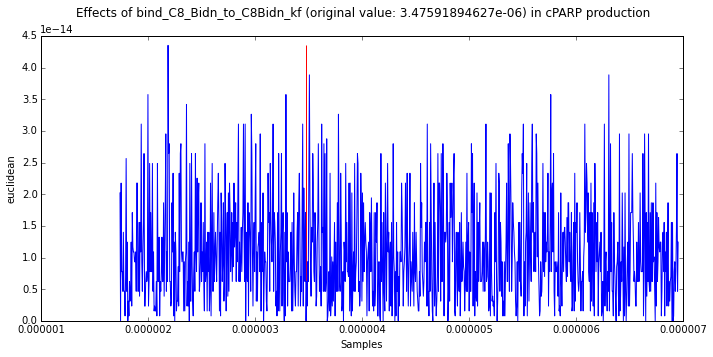

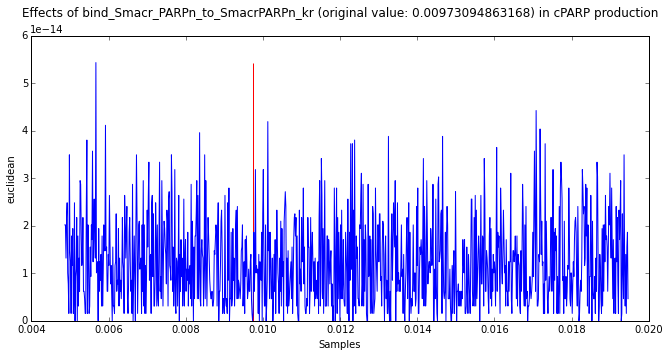

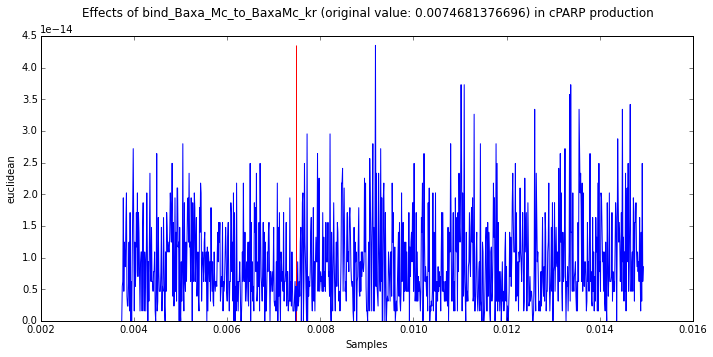

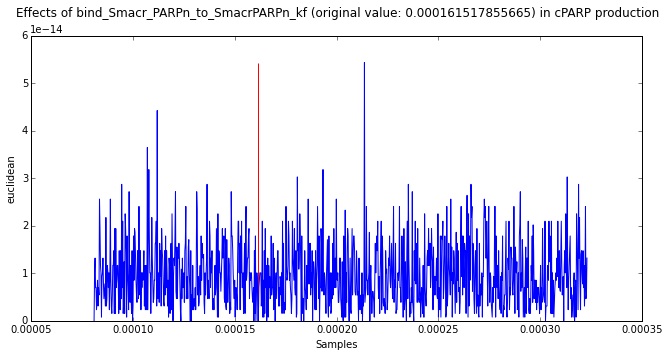

In [200]:
below_significant = {}
for output in ['mBid','aSmac','cPARP']:
    for parameter in perturbations[output].keys():
        messed_up = perturbations[output][parameter][0]        
        fig = plt.figure(figsize=(10,5))
        fig.autofmt_xdate()
        ax1 = fig.add_subplot(111)
        ax1.plot(messed_up.index.values,messed_up['euclidean'].values)
        ax1.vlines(perturbations[output][parameter][4]+0,messed_up['euclidean'].min(),
                   messed_up['euclidean'].max(),color='r')
        ax1.set_xlabel("Samples")
        ax1.set_ylabel("euclidean")


        ax1.set_title("Effects of {} (original value: {}) in {} production".format(parameter,perturbations[output][parameter][4],
                                                                                   output),y=1.05)
        fig.tight_layout()
plt.savefig('qsb_sensitivity/plots.png')

In [201]:
maxes = {}
for output in ['mBid','aSmac','cPARP']:
    for parameter in perturbations[output].keys():
        maximum = perturbations[output][parameter][0]['euclidean'].mean()
        if not output in maxes:
            maxes[output] = {}
        maxes[output][parameter] = maximum

In [206]:
maxes_table = pd.DataFrame.from_dict(maxes)

In [216]:
for output in ['mBid','aSmac','cPARP']:
    top_10 = maxes_table.sort(output,ascending=False).iloc[:10].index.values
    print("The most critical parameters for {} production are:".format(output))
    for x in top_10:
        print x
    print '\n'

The most critical parameters for mBid production are:
synthesize_C8_k
bind_C8_Bidn_to_C8Bidn_kf
bind_Bidt_Baxd_to_BidtBaxd_kf
bind_Bidt_Bcl2_kf
bind_Bidt_Bcl2_kr
bind_Baxa_Bcl2_kf
catalyze_C8Bidn_to_C8_Bidt_kc
catalyze_BidtBaxd_to_Bidt_Baxa_kc
bind_Baxa_Bcl2_kr
bind_Bidt_Baxd_to_BidtBaxd_kr


The most critical parameters for aSmac production are:
bind_C8_Bidn_to_C8Bidn_kf
bind_Bidt_Baxd_to_BidtBaxd_kf
synthesize_C8_k
catalyze_SmacrPARPn_to_Smacr_PARPc_kc
catalyze_C8Bidn_to_C8_Bidt_kc
bind_C8_Bidn_to_C8Bidn_kr
bind_Bidt_Bcl2_kr
catalyze_BidtBaxd_to_Bidt_Baxa_kc
bind_Baxa_Mc_to_BaxaMc_kf
bind_Smacr_PARPn_to_SmacrPARPn_kr


The most critical parameters for cPARP production are:
catalyze_C8Bidn_to_C8_Bidt_kc
bind_Baxa_Mc_to_BaxaMc_kf
catalyze_BidtBaxd_to_Bidt_Baxa_kc
bind_Smacr_PARPn_to_SmacrPARPn_kr
bind_Bidt_Baxd_to_BidtBaxd_kf
bind_Bidt_Bcl2_kf
synthesize_C8_k
catalyze_BaxaMc_to_Baxa_Mp_kc
bind_Mp_Smacm_to_MpSmacm_kf
bind_C8_Bidn_to_C8Bidn_kf


